# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак

- Price — цена (евро)

## Подготовка данных

In [1]:
# подгрузим необходимые библиотеки
!pip install phik

import pandas as pd
import numpy as np

import phik
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# откроем датасет и создадим переменную с изначальным размером
df = pd.read_csv('/datasets/autos.csv')
before = df.shape[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
# приведем названия к snake case для удобства и проверим результат
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [4]:
# проверим данные на наличие явных дубликатов
df.duplicated().sum()

4

In [5]:
# удалим явные дубликаты
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [6]:
# сразу удалим не информативные признаки date_crawled, date_created, number_of_pictures, postal_code, last_seen, registration_month
df = df.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'registration_month'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354365 non-null  int64 
 1   vehicle_type       316875 non-null  object
 2   registration_year  354365 non-null  int64 
 3   gearbox            334532 non-null  object
 4   power              354365 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          354365 non-null  int64 
 7   fuel_type          321470 non-null  object
 8   brand              354365 non-null  object
 9   repaired           283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [7]:
# посмотрим на первые 5 строк датасета
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [8]:
# проверим количество пропусков в данных
df.isna().sum()

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

In [9]:
# посмотрим некоторые описательные статистики по нашим признакам
for col in df.columns:
    print(col)
    print('=' * 20)
    print(df[col].describe())
    print('=' * 20)

price
count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64
vehicle_type
count     316875
unique         8
top        sedan
freq       91457
Name: vehicle_type, dtype: object
registration_year
count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64
gearbox
count     334532
unique         2
top       manual
freq      268249
Name: gearbox, dtype: object
power
count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64
model
count     334660
unique       250
top         golf
freq       29232
Name: model, dtype: object
k

По итогу небольшого анализа данных было выявлено много проблем которые нам предстоит решить. Во первых очень много пропусков в данных а во вторых во многих признаках присутствуют данные не соответствующие действительности (например год регистрации автомобиля - 1000 или 9999 Или мощность 20000 л.с.)

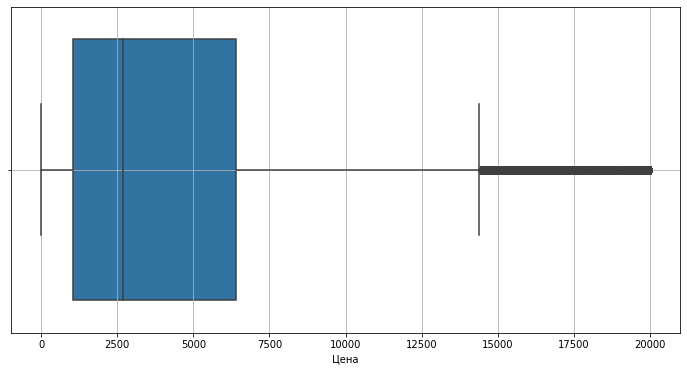

In [10]:
# изучим распределение в признаке price
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'])
plt.xlabel('Цена')
plt.grid(True)

plt.show()

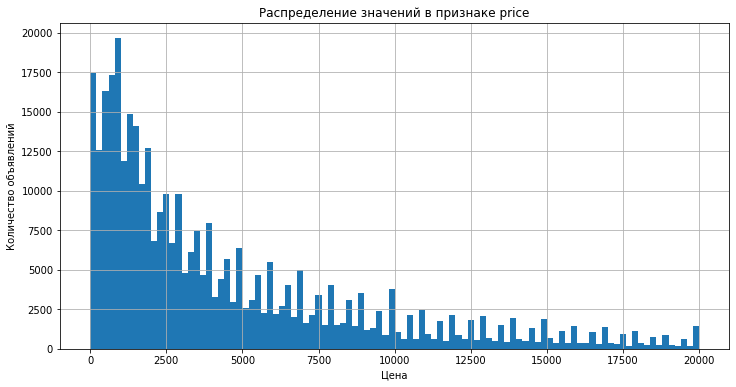

In [11]:
# построим гистограмму по признаку price
plt.figure(figsize=(12, 6))
df['price'].plot(kind='hist', bins=100, grid=True)
plt.title('Распределение значений в признаке price')
plt.xlabel('Цена')
plt.ylabel('Количество объявлений')

plt.show()

In [12]:
# так как выбросы выше 14000 евро могут быть вполне реальными данными то оставим их без изменений
# а вот нулевых или очень маленьких значений не божет быть
# посмотрим на 0.05 квантиль и удалим все значения ниже
df['price'].quantile(.05)

200.0

In [13]:
# удалим все позиции с ценой ниже 200 евро
df = df.loc[df['price'] >= 200]

In [14]:
# рассмотрим признак vehicle_type
df['vehicle_type'].value_counts()

sedan          88574
small          75625
wagon          63130
bus            28213
convertible    19778
coupe          15444
suv            11754
other           3005
Name: vehicle_type, dtype: int64

In [15]:
# так как мы не можем восстанавить пропущенные данные в признаке vehicle_type заменим их на unknown
df['vehicle_type'].fillna('unknown', inplace=True)
df['vehicle_type'].value_counts()

sedan          88574
small          75625
wagon          63130
unknown        31380
bus            28213
convertible    19778
coupe          15444
suv            11754
other           3005
Name: vehicle_type, dtype: int64

In [16]:
# рассмотрим признак registration_year
df['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015,
       1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 2066, 1949,
       2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300, 9000, 2900,
       6000, 5900, 1000, 5911, 1400, 5000, 4000, 1948, 1952, 8500, 1932,
       1950, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 3000, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       1600, 1111, 1039, 2800, 1931, 4500, 1602, 7800, 1947, 1927, 7100,
       1300, 8200, 1946])

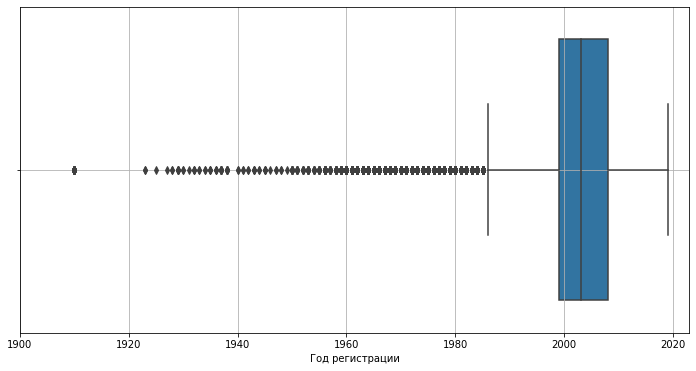

In [17]:
# изучим распределение в признаке registration_year
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['registration_year'])
plt.xlim(1900, 2023)
plt.xlabel('Год регистрации')
plt.grid(True)

plt.show()

In [18]:
# верхняя граница достоверного года регистрации находится на 2016 так как последняя дата скачивания анкеты date_crawled 2016г
df.loc[df['registration_year'] >= 2016, 'registration_year'].unique()

array([2016, 2018, 2017, 3200, 9999, 8888, 2200, 4100, 2066, 2019, 5300,
       9000, 2900, 6000, 5900, 5911, 5000, 4000, 8500, 3700, 3800, 4800,
       7000, 3000, 2290, 9450, 2500, 5555, 2800, 4500, 7800, 7100, 8200])

In [19]:
# так как выбросы в сторону нижней границы начинаются примерно в районе 1985 года, было принято
# решение удалить все выбросы ниже 1985 г. и выше 2016
df = df.loc[(df['registration_year'] >= 1985) & (df['registration_year'] <= 2016)]

In [20]:
# рассмотрим признак gearbox
df['gearbox'].value_counts()

manual    243705
auto       61608
Name: gearbox, dtype: int64

In [21]:
# так как у нас нет возможности восстановить истинные данные заполним пропуски unknown
df['gearbox'].fillna('unknown', inplace=True)
df['gearbox'].value_counts()

manual     243705
auto        61608
unknown     13166
Name: gearbox, dtype: int64

In [22]:
# рассмотрим признак power
df['power'].describe()

count    318479.000000
mean        113.554966
std         183.758446
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

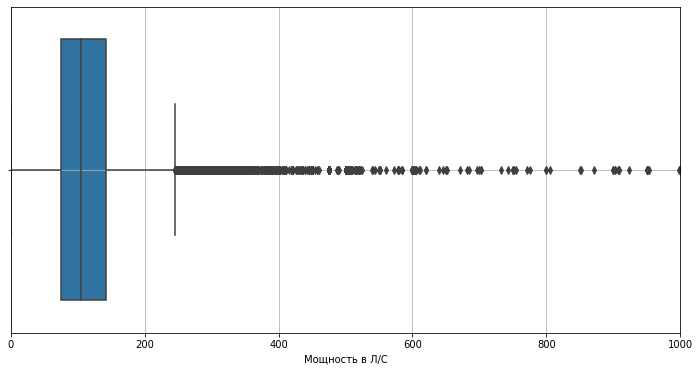

In [23]:
# изучим распределение в признаке power
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['power'])
plt.xlim(0, 1000)
plt.xlabel('Мощность в Л/С')
plt.grid(True)

plt.show()

Удалим все ниже 15 Л/С так как модели авто мощностью ниже это единичные случаи, также удалим все выше 600 Л/С, подобные авто не попадают в наш ценовой диапазон.

In [24]:
# удалим всt что ниже 15 Л/С и выше 600 Л/С
df = df.loc[(df['power'] >= 15) & (df['power'] <= 600)]
df['power'].describe()

count    288866.000000
mean        121.412998
std          53.532057
min          15.000000
25%          80.000000
50%         114.000000
75%         150.000000
max         600.000000
Name: power, dtype: float64

In [25]:
# заменим пропуски в признаке model на unknown так как мы не можем восстановить достоверные данные
df['model'].fillna('unknown', inplace=True)
df['model'].value_counts()

golf                  24217
other                 18579
3er                   17235
polo                  10323
unknown               10092
                      ...  
kalina                    5
i3                        5
samara                    5
rangerover                2
range_rover_evoque        2
Name: model, Length: 248, dtype: int64

In [26]:
# в признаке kilometer все в порядке, исправления не требуются
df['kilometer'].describe()

count    288866.000000
mean     128608.610913
std       36376.811729
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [27]:
# заменим пропуски в признаке fuel_type на unknown так как мы не можем восстановить достоверные данные
df['fuel_type'].fillna('unknown', inplace=True)
df['fuel_type'].value_counts()

petrol      181620
gasoline     87254
unknown      14558
lpg           4641
cng            477
hybrid         201
other           70
electric        45
Name: fuel_type, dtype: int64

In [28]:
# рассмотрим признак brand
# проблем не обнаружено
df['brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'lancia', 'citroen', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

In [29]:
# заменим пропуски в признаке repaired на unknown так как мы не можем восстановить достоверные данные
df['repaired'].fillna('unknown', inplace=True)
df['repaired'].value_counts()

no         220981
unknown     40776
yes         27109
Name: repaired, dtype: int64

In [30]:
# расчитаем сколько процентов от изначальных данных у нас осталось после обработки
after = df.shape[0]
after / before * 100

81.51559532577623

После очистки данных осталось около 81,5% датасета. Есть мнение что удалить пропуски было бы лучшим вариантом но пока решено оставить заглушку.

In [31]:
# сбросим индексы
df.reset_index(drop=True, inplace=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


## Обучение моделей

In [32]:
# разделим датасет на признаки и таргет
X = df.drop('price', axis=1)
y = df['price']
rs = 42

In [33]:
# разделим данные на тренировочные и валидационные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

# проверим размеры наших выборок
display(f'Размер тренировочной выборки: {X_train.shape[0]} строки {X_train.shape[1]} столбцов')
display(f'Размер тренировочного целевого признака: {y_train.shape[0]} строки')
display(f'Размер тестовой выборки: {X_test.shape[0]} строк {X_test.shape[1]} столбцов')
display(f'Размер тестового целевого признака: {y_test.shape[0]} строк')

'Размер тренировочной выборки: 231092 строки 9 столбцов'

'Размер тренировочного целевого признака: 231092 строки'

'Размер тестовой выборки: 57774 строк 9 столбцов'

'Размер тестового целевого признака: 57774 строк'

In [34]:
# создадим список категориальных признаков
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [35]:
# с помощью OrdinalEncoder закодируем наши признаки и приведем все к int16
encoder = OrdinalEncoder(dtype=np.int16)
encoder.fit(X_train[cat_features])
X_train[cat_features] = encoder.transform(X_train[cat_features])
X_train = X_train.astype(np.int16)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231092 entries, 15284 to 121958
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   vehicle_type       231092 non-null  int16
 1   registration_year  231092 non-null  int16
 2   gearbox            231092 non-null  int16
 3   power              231092 non-null  int16
 4   model              231092 non-null  int16
 5   kilometer          231092 non-null  int16
 6   fuel_type          231092 non-null  int16
 7   brand              231092 non-null  int16
 8   repaired           231092 non-null  int16
dtypes: int16(9)
memory usage: 5.7 MB


In [36]:
# с помощью OrdinalEncoder закодируем наши признаки и приведем все к int16
X_test[cat_features] = encoder.transform(X_test[cat_features])
X_test = X_test.astype(np.int16)

y_train = y_train.astype(np.int16)
y_test = y_test.astype(np.int16)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57774 entries, 56107 to 271749
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   vehicle_type       57774 non-null  int16
 1   registration_year  57774 non-null  int16
 2   gearbox            57774 non-null  int16
 3   power              57774 non-null  int16
 4   model              57774 non-null  int16
 5   kilometer          57774 non-null  int16
 6   fuel_type          57774 non-null  int16
 7   brand              57774 non-null  int16
 8   repaired           57774 non-null  int16
dtypes: int16(9)
memory usage: 1.4 MB


In [37]:
%%time
# подберем лучшие параметры для модели RandomForestRegressor
# выведем на экран лучшие параметры и rmse

RFR = RandomForestRegressor(random_state=rs) 
params = {'max_depth': np.arange(2, 17, 2),
          'n_estimators': np.arange(40, 71, 10)}

grid = GridSearchCV(RFR, 
                    param_grid=params, 
                    scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

print(grid.best_params_)
    
rmse_RFR = (max(grid.cv_results_['mean_test_score']) * -1) ** .5
rmse_RFR

{'max_depth': 16, 'n_estimators': 70}
CPU times: user 34min 38s, sys: 9.64 s, total: 34min 48s
Wall time: 34min 49s


1566.3004146511853

In [41]:
%%time
# подберем лучшие параметры для модели CatBoostRegressor
# выведем на экран лучшие параметры и rmse

CBR = CatBoostRegressor(loss_function='RMSE', random_state=rs, verbose=False) 
params = {'depth': [8, 10],
          'learning_rate': np.arange(0.1, 0.4, 0.1)}

grid = GridSearchCV(CBR,
                    param_grid=params, 
                    scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

print(grid.best_params_)
    
rmse_CBR = (max(grid.cv_results_['mean_test_score']) * -1) ** .5
rmse_CBR

{'depth': 10, 'learning_rate': 0.2}
CPU times: user 30min 46s, sys: 13.6 s, total: 31min
Wall time: 32min


1470.9005651880886

In [44]:
%%time
# подберем лучшие параметры для модели LGBMRegressor
# выведем на экран лучшие параметры и rmse

LGBMR = LGBMRegressor(random_state=rs) 
params = {'num_leaves': [50, 75, 100], 
          'learning_rate': [.1, .2]}

grid = GridSearchCV(LGBMR,
                    param_grid=params, 
                    scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

print(grid.best_params_)

rmse_LGBMR = (max(grid.cv_results_['mean_test_score']) * -1) ** .5
rmse_LGBMR

{'learning_rate': 0.2, 'num_leaves': 100}
CPU times: user 13min 15s, sys: 7.43 s, total: 13min 22s
Wall time: 13min 28s


1512.5371241206137

Расчитаем время обучения, время предсказания и качество моделей.

RandomForestRegressor

In [45]:
%%time
# выведем время обучения RandomForestRegressor

RFR = RandomForestRegressor(random_state=rs, max_depth=16, n_estimators=70)
RFR.fit(X_train, y_train)

CPU times: user 39 s, sys: 59.9 ms, total: 39.1 s
Wall time: 39.2 s


RandomForestRegressor(max_depth=16, n_estimators=70, random_state=42)

In [46]:
%%time
# выведем время предсказания RandomForestRegressor

RFR_predict = RFR.predict(X_train)

CPU times: user 3.75 s, sys: 3 µs, total: 3.75 s
Wall time: 3.76 s


In [47]:
# выведем rmse для RandomForestRegressor

RFR_rmse = mean_squared_error(y_train, RFR_predict, squared=False)
RFR_rmse

1206.7490276132594

CatBoostRegressor

In [48]:
%%time
# выведем время обучения CatBoostRegressor

CBR = CatBoostRegressor(loss_function='RMSE', random_state=rs, metric_period=1000, depth=10, learning_rate=0.2)
CBR.fit(X_train, y_train)

0:	learn: 3931.3765849	total: 78.9ms	remaining: 1m 18s
999:	learn: 1195.7098339	total: 1m 16s	remaining: 0us
CPU times: user 1min 16s, sys: 332 ms, total: 1min 16s
Wall time: 1min 18s


In [49]:
%%time
# выведем время предсказания CatBoostRegressor

CBR_predict = CBR.predict(X_train)

CPU times: user 1.17 s, sys: 18 µs, total: 1.17 s
Wall time: 1.17 s


In [50]:
# выведем rmse для CatBoostRegressor

CBR_rmse = mean_squared_error(y_train, CBR_predict, squared=False)
CBR_rmse

1195.709833939465

LGBMRegressor

In [53]:
%%time
# выведем время обучения LGBMRegressor

LGBMR = LGBMRegressor(random_state=rs, learning_rate=0.2, num_leaves=100)
LGBMR.fit(X_train, y_train)

CPU times: user 10.1 s, sys: 44 ms, total: 10.1 s
Wall time: 10.2 s


LGBMRegressor(learning_rate=0.2, num_leaves=100, random_state=42)

In [54]:
%%time
# выведем время предсказания LGBMRegressor

LGBMR_predict = LGBMR.predict(X_train)

CPU times: user 1.88 s, sys: 5.54 ms, total: 1.88 s
Wall time: 1.9 s


In [55]:
# выведем rmse для LGBMRegressor

LGBMR_rmse = mean_squared_error(y_train, LGBMR_predict, squared=False)
LGBMR_rmse

1394.751277191849

In [56]:
# выведем на экран таблицу с итогами исследования
models = ['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
table = pd.DataFrame(np.array([RFR_rmse, CBR_rmse, LGBMR_rmse]), index=models)
table.set_axis(['rmse'], axis=1, inplace=True)
table['train_time'] = ['39.2 s', '1min 18s', '10.2 s']
table['prediction_time'] = ['3.76 s', '1.17 s', '1.9 s']

table

,rmse,train_time,prediction_time
RandomForestRegressor,1206.749028,39.2 s,3.76 s
CatBoostRegressor,1195.709834,1min 18s,1.17 s
LGBMRegressor,1394.751277,10.2 s,1.9 s


DummyRegressor

In [58]:
# провеверим модели на адекватность сравнением с константной моделью
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_predict = dummy.predict(X_train)

dummy_rmse = mean_squared_error(y_train, dummy_predict, squared=False)
dummy_rmse

4591.195962901054

## Анализ моделей

Были обучены 3 модели: RandomForestRegressor, CatBoostRegressor, LGBMRegressor. С помощью GridSearchCV подобраны лучшие параметры. Адекватность моделей подтверждена сравнением с показателями на константной моделе. По метрике RMSE и по скорости предсказания модель CatBoostRegressor значительно превзошла другие модели, проиграв лишь во времени обучения. Считаю что мы можем оставить для дальнейшей работы модель CatBoostRegressor так как она продемонстрировала лучшие результаты в 2 из 3 параметров оценки модели. Проверим модель CatBoostRegressor на тестовой выборке.

# Тестирование лучшей модели

В данной ситуации рекомендую модель CatBoostRegressor. Посмотрим на показатели на тестовых данных.

In [61]:
%%time
# выведем время обучения CatBoostRegressor

CBR = CatBoostRegressor(loss_function='RMSE', random_state=rs, metric_period=1000, depth=10, learning_rate=0.2)
CBR.fit(X_train, y_train)

0:	learn: 3931.3765849	total: 66.6ms	remaining: 1m 6s
999:	learn: 1195.7098339	total: 58.9s	remaining: 0us
CPU times: user 59.1 s, sys: 177 ms, total: 59.3 s
Wall time: 60 s


In [62]:
%%time
# выведем время предсказания CatBoostRegressor

CBR_predict = CBR.predict(X_test)

CPU times: user 292 ms, sys: 3 µs, total: 292 ms
Wall time: 297 ms


In [63]:
# выведем rmse для CatBoostRegressor

CBR_rmse = mean_squared_error(y_test, CBR_predict, squared=False)
CBR_rmse

1436.2098621307591

Модель CatBoostRegressor продемонстрировала на тестовых данных следующие показатели:

    - train time - 60 s
    - predict time - 297 ms
    - RMSE - 1436.21